In [1]:
import os
import random
import logging
import numpy as np
import pandas as pd

# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
from tqdm import trange

import pprint
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler

from pytorch_pretrained_bert.tokenization import BertTokenizer
from pytorch_pretrained_bert.modeling import BertForSequenceClassification
from pytorch_pretrained_bert.optimization import BertAdam
from pytorch_pretrained_bert.file_utils import PYTORCH_PRETRAINED_BERT_CACHE

from nltk import sent_tokenize, word_tokenize

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"]="6,7"
os.environ["TFHUB_CACHE_DIR"]="tfhub_modules"

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

pp = pprint.PrettyPrinter(indent=4)

In [2]:
local_rank = -1
max_seq_length = 200
bert_model = "bert-base-uncased"
do_lower_case = True
num_labels = 7
gradient_accumulation_steps = 1
train_batch_size = 32
eval_batch_size = 8
test_batch_size = 8
learning_rate = 5e-5
num_train_epochs = 3.0
warmup_proportion = 0.1
output_dir = "bert"
do_train = True
do_eval = True
fp16 = True
loss_scale = 0

In [3]:
if local_rank == -1:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    n_gpu = torch.cuda.device_count()
else:
    torch.cuda.set_device(local_rank)
    device = torch.device("cuda", local_rank)
    n_gpu = 1
    # Initializes the distributed backend which will take care of sychronizing nodes/GPUs
    torch.distributed.init_process_group(backend='nccl')

seed = 20190104

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if n_gpu > 0:
    torch.cuda.manual_seed_all(seed)

In [4]:
logger.info("device: {}, n_gpu: {}, distributed training: {}, 16-bits training: {}".format(
    device, n_gpu, bool(local_rank != -1), fp16))

01/25/2019 14:22:52 - INFO - __main__ -   device: cuda, n_gpu: 2, distributed training: False, 16-bits training: True


## Tokenizer Comparison - NLTK Tokenizer vs BertTokenizer

In [5]:
sentences = [
    "I love Kung Fu Panda and chicken tikka masala!",
    "Divide each difficulty into as many parts as is feasible and necessary to resolve it.",
    "It is not enough to have a good mind; the main thing is to use it well.",
]

### NLTK Tokenizer

In [6]:
nltk_tokenized_text = [word_tokenize(sentence.lower()) for sentence in sentences]
pp.pprint(nltk_tokenized_text)

[   [   'i',
        'love',
        'kung',
        'fu',
        'panda',
        'and',
        'chicken',
        'tikka',
        'masala',
        '!'],
    [   'divide',
        'each',
        'difficulty',
        'into',
        'as',
        'many',
        'parts',
        'as',
        'is',
        'feasible',
        'and',
        'necessary',
        'to',
        'resolve',
        'it',
        '.'],
    [   'it',
        'is',
        'not',
        'enough',
        'to',
        'have',
        'a',
        'good',
        'mind',
        ';',
        'the',
        'main',
        'thing',
        'is',
        'to',
        'use',
        'it',
        'well',
        '.']]


### BertTokenizer

In [7]:
bert_tokenizer = BertTokenizer.from_pretrained(bert_model, do_lower_case=do_lower_case)
bert_tokenized_text = [bert_tokenizer.tokenize(sentence) for sentence in sentences]
pp.pprint(bert_tokenized_text)

01/25/2019 14:23:18 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/david/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


[   [   'i',
        'love',
        'kung',
        'fu',
        'panda',
        'and',
        'chicken',
        'ti',
        '##kka',
        'mas',
        '##ala',
        '!'],
    [   'divide',
        'each',
        'difficulty',
        'into',
        'as',
        'many',
        'parts',
        'as',
        'is',
        'feasible',
        'and',
        'necessary',
        'to',
        'resolve',
        'it',
        '.'],
    [   'it',
        'is',
        'not',
        'enough',
        'to',
        'have',
        'a',
        'good',
        'mind',
        ';',
        'the',
        'main',
        'thing',
        'is',
        'to',
        'use',
        'it',
        'well',
        '.']]


## Data Preprocessing

In [8]:
label_list = ["anger", "sadness", "joy"]
label_map = {label : i for i, label in enumerate(label_list)}
logger.info(label_map)

01/25/2019 14:23:18 - INFO - __main__ -   {'anger': 0, 'sadness': 1, 'joy': 2}


In [9]:
class ISEARDataset(object):
    FILENAME = "data/isear_databank.csv"
    RANDOM_STATE = 41
  
    def get_labels(self):
        return ["anger", "disgust", "fear", "guilt", "joy", "sadness", "shame"]
  
    def get_label_map(self):
        return {label : i for i, label in enumerate(self.get_labels())}
    
    def len(self):
        return len(self.data.index)

    def __init__(self, n_items=0):
        data = pd.read_csv(self.FILENAME)

        if n_items > 0:
            data = data.iloc[0:n_items,:]

        data["text"] = data["SIT"]
        data["label"] = data["Field1"]

        for label in self.get_labels():
            data.loc[data["label"] == label, "label_int"] = self.get_label_map()[label]
            
        self.data = data[["text", "label", "label_int"]]

In [10]:
dataset = ISEARDataset()

train_dataset, test_dataset = train_test_split(dataset.data, test_size=0.3, random_state=dataset.RANDOM_STATE, stratify=dataset.data.label)
train_dataset, eval_dataset = train_test_split(train_dataset, test_size=0.2, random_state=dataset.RANDOM_STATE, stratify=train_dataset.label)

In [11]:
for (row_index, row) in train_dataset.iterrows():
    logger.info("row index:{}".format(row_index))
    logger.info("text:{}".format(row.text))
    logger.info("label:{}".format(row.label))
    logger.info("label_int:{}".format(row.label_int))
    break

01/25/2019 14:23:18 - INFO - __main__ -   row index:6800
01/25/2019 14:23:18 - INFO - __main__ -   text:The time when my sister had her first baby I was so happy and á
joyous because she stayed for two days after marriage before she á
had a child.
01/25/2019 14:23:18 - INFO - __main__ -   label:joy
01/25/2019 14:23:18 - INFO - __main__ -   label_int:4.0


In [12]:
class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_id):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id
        
def convert_dataset_to_features(dataset, label_map, max_seq_length, tokenizer):
    """Loads a data file into a list of `InputBatch`s."""

    features = []
    index = 0
    for (guid, row) in dataset.iterrows():
        tokens = tokenizer.tokenize(row.text)

        # Account for [CLS] and [SEP] with "- 2"
        if len(tokens) > max_seq_length - 2:
            tokens = tokens[:(max_seq_length - 2)]

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids: 0   0  0    0    0     0       0 0    1  1  1  1   1 1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids: 0   0   0   0  0     0 0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambigiously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens = ["[CLS]"] + tokens + ["[SEP]"]
        segment_ids = [0] * len(tokens)

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        label_id = label_map[row.label]
        if index < 5:
            logger.info("*** row ***")
            logger.info("guid: %s" % (guid))
            logger.info("tokens: %s" % " ".join(
                    [str(x) for x in tokens]))
            logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
            logger.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
            logger.info(
                    "segment_ids: %s" % " ".join([str(x) for x in segment_ids]))
            logger.info("label: %s (id = %d)" % (row.label, label_id))

        features.append(
                InputFeatures(input_ids=input_ids,
                              input_mask=input_mask,
                              segment_ids=segment_ids,
                              label_id=label_id))
        index += 1
        
    return features


def _truncate_seq_pair(tokens, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""

    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens) > len(tokens_b):
            tokens.pop()
        else:
            tokens_b.pop()

In [13]:
train_features = convert_dataset_to_features(train_dataset, dataset.get_label_map(), max_seq_length, bert_tokenizer)

01/25/2019 14:23:18 - INFO - __main__ -   *** row ***
01/25/2019 14:23:18 - INFO - __main__ -   guid: 6800
01/25/2019 14:23:18 - INFO - __main__ -   tokens: [CLS] the time when my sister had her first baby i was so happy and a joy ##ous because she stayed for two days after marriage before she a had a child . [SEP]
01/25/2019 14:23:18 - INFO - __main__ -   input_ids: 101 1996 2051 2043 2026 2905 2018 2014 2034 3336 1045 2001 2061 3407 1998 1037 6569 3560 2138 2016 4370 2005 2048 2420 2044 3510 2077 2016 1037 2018 1037 2775 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
01/25/2019 14:23:18 - INFO - __main__ -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 

01/25/2019 14:23:18 - INFO - __main__ -   segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
01/25/2019 14:23:18 - INFO - __main__ -   label: shame (id = 6)


In [14]:
eval_features = convert_dataset_to_features(eval_dataset, dataset.get_label_map(), max_seq_length, bert_tokenizer)

01/25/2019 14:23:21 - INFO - __main__ -   *** row ***
01/25/2019 14:23:21 - INFO - __main__ -   guid: 3305
01/25/2019 14:23:21 - INFO - __main__ -   tokens: [CLS] when i decided to leave my steady , secure employment to come to a university . because i didn ' t know if i could cope with all the a requirements of study and also being older i didn ' t know if i a would enjoy mixing with younger people , also financial a ins ##ec ##urity . [SEP]
01/25/2019 14:23:21 - INFO - __main__ -   input_ids: 101 2043 1045 2787 2000 2681 2026 6706 1010 5851 6107 2000 2272 2000 1037 2118 1012 2138 1045 2134 1005 1056 2113 2065 1045 2071 11997 2007 2035 1996 1037 5918 1997 2817 1998 2036 2108 3080 1045 2134 1005 1056 2113 2065 1045 1037 2052 5959 6809 2007 3920 2111 1010 2036 3361 1037 16021 8586 25137 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

01/25/2019 14:23:21 - INFO - __main__ -   segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
01/25/2019 14:23:21 - INFO - __main__ -   label: sadness (id = 5)


In [15]:
test_features = convert_dataset_to_features(test_dataset, dataset.get_label_map(), max_seq_length, bert_tokenizer)

01/25/2019 14:23:21 - INFO - __main__ -   *** row ***
01/25/2019 14:23:21 - INFO - __main__ -   guid: 3559
01/25/2019 14:23:21 - INFO - __main__ -   tokens: [CLS] a person i know who tells lies and so pretending to be better a than she is . [SEP]
01/25/2019 14:23:21 - INFO - __main__ -   input_ids: 101 1037 2711 1045 2113 2040 4136 3658 1998 2061 12097 2000 2022 2488 1037 2084 2016 2003 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
01/25/2019 14:23:21 - INFO - __main__ -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

01/25/2019 14:23:21 - INFO - __main__ -   segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
01/25/2019 14:23:21 - INFO - __main__ -   label: sadness (id = 5)


In [16]:
# Prepare model
model = BertForSequenceClassification.from_pretrained(
    bert_model,
    cache_dir=PYTORCH_PRETRAINED_BERT_CACHE / 'distributed_{}'.format(local_rank),
    num_labels = num_labels
)
model.to(device)

if fp16:
    model.half()
        
if local_rank != -1:
    try:
        from apex.parallel import DistributedDataParallel as DDP
    except ImportError:
        raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use distributed and fp16 training.")

    model = DDP(model)
elif n_gpu > 1:
    model = torch.nn.DataParallel(model)

01/25/2019 14:23:23 - INFO - pytorch_pretrained_bert.modeling -   loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at /home/david/.pytorch_pretrained_bert/distributed_-1/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
01/25/2019 14:23:23 - INFO - pytorch_pretrained_bert.modeling -   extracting archive file /home/david/.pytorch_pretrained_bert/distributed_-1/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /tmp/tmph69q1q0m
01/25/2019 14:23:28 - INFO - pytorch_pretrained_bert.modeling -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers":

In [17]:
param_optimizer = list(model.named_parameters())

In [18]:
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

train_batch_size = int(train_batch_size / gradient_accumulation_steps)
logger.info("train_batch_size = {}".format(train_batch_size))
logger.info("num train_dataset = {}".format(len(train_dataset)))
logger.info("gradient_accumulation_steps = {}".format(gradient_accumulation_steps))
logger.info("num_train_epochs = {}".format(num_train_epochs))

num_train_steps = int(
    len(train_dataset) / train_batch_size / gradient_accumulation_steps * num_train_epochs
)
logger.info("num_train_steps = {}".format(num_train_steps))

t_total = num_train_steps

if local_rank != -1:
    t_total = t_total // torch.distributed.get_world_size()

logger.info("t_total = {}".format(t_total))

01/25/2019 14:23:38 - INFO - __main__ -   train_batch_size = 32
01/25/2019 14:23:38 - INFO - __main__ -   num train_dataset = 4292
01/25/2019 14:23:38 - INFO - __main__ -   gradient_accumulation_steps = 1
01/25/2019 14:23:38 - INFO - __main__ -   num_train_epochs = 3.0
01/25/2019 14:23:38 - INFO - __main__ -   num_train_steps = 402
01/25/2019 14:23:38 - INFO - __main__ -   t_total = 402


In [19]:
if fp16:
    try:
        from apex.optimizers import FP16_Optimizer
        from apex.optimizers import FusedAdam
    except ImportError:
        raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use distributed and fp16 training.")

    optimizer = FusedAdam(optimizer_grouped_parameters,
                          lr=learning_rate,
                          bias_correction=False,
                          max_grad_norm=1.0)
    if loss_scale == 0:
        optimizer = FP16_Optimizer(optimizer, dynamic_loss_scale=True)
    else:
        optimizer = FP16_Optimizer(optimizer, static_loss_scale=loss_scale)

else:
    optimizer = BertAdam(optimizer_grouped_parameters,
                         lr=learning_rate,
                         warmup=warmup_proportion,
                         t_total=t_total)

In [20]:
global_step = 0
nb_tr_steps = 0
tr_loss = 0
    
logger.info("***** Running training *****")
logger.info("  Num examples = %d", len(train_dataset))
logger.info("  Batch size = %d", train_batch_size)
logger.info("  Num steps = %d", num_train_steps)
train_input_ids = torch.tensor([f.input_ids for f in train_features], dtype=torch.long)
train_input_mask = torch.tensor([f.input_mask for f in train_features], dtype=torch.long)
train_segment_ids = torch.tensor([f.segment_ids for f in train_features], dtype=torch.long)
train_label_ids = torch.tensor([f.label_id for f in train_features], dtype=torch.long)

01/25/2019 14:23:38 - INFO - __main__ -   ***** Running training *****
01/25/2019 14:23:38 - INFO - __main__ -     Num examples = 4292
01/25/2019 14:23:38 - INFO - __main__ -     Batch size = 32
01/25/2019 14:23:38 - INFO - __main__ -     Num steps = 402


In [21]:
train_input_ids

tensor([[ 101, 1996, 2051,  ...,    0,    0,    0],
        [ 101, 2043, 1045,  ...,    0,    0,    0],
        [ 101, 2387, 2026,  ...,    0,    0,    0],
        ...,
        [ 101, 1037, 2154,  ...,    0,    0,    0],
        [ 101, 2019, 8875,  ...,    0,    0,    0],
        [ 101, 2043, 2026,  ...,    0,    0,    0]])

In [22]:
train_input_ids[0]

tensor([ 101, 1996, 2051, 2043, 2026, 2905, 2018, 2014, 2034, 3336, 1045, 2001,
        2061, 3407, 1998, 1037, 6569, 3560, 2138, 2016, 4370, 2005, 2048, 2420,
        2044, 3510, 2077, 2016, 1037, 2018, 1037, 2775, 1012,  102,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   

In [23]:
train_input_ids.shape

torch.Size([4292, 200])

In [24]:
train_input_mask

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [25]:
train_input_mask[0]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [26]:
train_input_mask.shape

torch.Size([4292, 200])

In [27]:
train_segment_ids

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [28]:
train_segment_ids[0]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [29]:
train_segment_ids.shape

torch.Size([4292, 200])

In [30]:
train_label_ids

tensor([4, 4, 1,  ..., 6, 3, 5])

In [31]:
train_label_ids[0]

tensor(4)

In [32]:
train_label_ids.shape

torch.Size([4292])

In [33]:
train_data = TensorDataset(train_input_ids, train_input_mask, train_segment_ids, train_label_ids)
if local_rank == -1:
    train_sampler = RandomSampler(train_data)
else:
    train_sampler = DistributedSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=train_batch_size)

In [34]:
train_sampler

In [35]:
logger.info("num_train_epochs = {}".format(num_train_epochs))

01/25/2019 14:23:38 - INFO - __main__ -   num_train_epochs = 3.0


In [36]:
def calc_accuracy(preds, labels):
    return np.sum(preds == labels)

def warmup_linear(x, warmup=0.002):
    if x < warmup:
        return x/warmup
    return 1.0 - x

In [37]:
model.train()
for _ in trange(int(num_train_epochs), desc="Epoch"):
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(tqdm(train_dataloader, desc="Iteration")):
        batch = tuple(t.to(device) for t in batch)
        train_input_ids, train_input_mask, train_segment_ids, train_label_ids = batch
        loss = model(train_input_ids, train_segment_ids, train_input_mask, train_label_ids)
        if n_gpu > 1:
            loss = loss.mean() # mean() to average on multi-gpu.
        if gradient_accumulation_steps > 1:
            loss = loss / gradient_accumulation_steps
            
        if fp16:
            optimizer.backward(loss)
        else:
            loss.backward()
            
        tr_loss += loss.item()
        nb_tr_examples += train_input_ids.size(0)
        nb_tr_steps += 1
        if (step + 1) % gradient_accumulation_steps == 0:
            # modify learning rate with special warm up BERT uses
            lr_this_step = learning_rate * warmup_linear(global_step/t_total, warmup_proportion)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr_this_step
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1

train_loss = tr_loss/nb_tr_steps if do_train else None

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

/home/david/anaconda3/envs/tf36/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '



Grad overflow on iteration 0
Using dynamic loss scale of 4294967296

Grad overflow on iteration 1
Using dynamic loss scale of 2147483648.0

Grad overflow on iteration 2
Using dynamic loss scale of 1073741824.0

Grad overflow on iteration 3
Using dynamic loss scale of 536870912.0

Grad overflow on iteration 4
Using dynamic loss scale of 268435456.0

Grad overflow on iteration 5
Using dynamic loss scale of 134217728.0

Grad overflow on iteration 6
Using dynamic loss scale of 67108864.0

Grad overflow on iteration 7
Using dynamic loss scale of 33554432.0

Grad overflow on iteration 8
Using dynamic loss scale of 16777216.0

Grad overflow on iteration 9
Using dynamic loss scale of 8388608.0

Grad overflow on iteration 10
Using dynamic loss scale of 4194304.0

Grad overflow on iteration 11
Using dynamic loss scale of 2097152.0

Grad overflow on iteration 12
Using dynamic loss scale of 1048576.0

Grad overflow on iteration 13
Using dynamic loss scale of 524288.0

Grad overflow on iteration 1

Epoch:  33%|███▎      | 1/3 [01:27<02:54, 87.46s/it]

Epoch:  67%|██████▋   | 2/3 [02:50<01:26, 86.10s/it]

Epoch: 100%|██████████| 3/3 [04:14<00:00, 85.39s/it]


In [38]:
# Save a trained model
model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
output_model_file = "pytorch_isear_bert_model.pt"
torch.save(model_to_save.state_dict(), output_model_file)

# Load a trained model that you have fine-tuned
model_state_dict = torch.load(output_model_file)
model = BertForSequenceClassification.from_pretrained(bert_model, state_dict=model_state_dict, num_labels=num_labels)
model.to(device)

01/25/2019 14:28:29 - INFO - pytorch_pretrained_bert.modeling -   loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at /home/david/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
01/25/2019 14:28:29 - INFO - pytorch_pretrained_bert.modeling -   extracting archive file /home/david/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /tmp/tmpl42d5x92
01/25/2019 14:28:33 - INFO - pytorch_pretrained_bert.modeling -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
 

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=T

## Evaluate the model

In [39]:
def evaluate(mode, features, batch_size):
    logger.info("***** Running {} *****".format(mode))
    logger.info("  Num examples = %d", len(features))
    logger.info("  Batch size = %d", batch_size)
    
    input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    data = TensorDataset(input_ids, input_mask, segment_ids, label_ids)
    
    # Run prediction for full data
    sampler = SequentialSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)

    model.eval()
    loss, accuracy = 0, 0
    nb_steps, nb_examples = 0, 0
    all_pred_label_ids = []
    all_actual_label_ids = []

    for input_ids, input_mask, segment_ids, label_ids in tqdm(dataloader, desc=mode):
        input_ids = input_ids.to(device)
        input_mask = input_mask.to(device)
        segment_ids = segment_ids.to(device)
        label_ids = label_ids.to(device)

        with torch.no_grad():
            tmp_loss = model(input_ids, segment_ids, input_mask, label_ids)
            logits = model(input_ids, segment_ids, input_mask)

        logits = logits.detach().cpu().numpy()
        preds = np.argmax(logits, axis=1)
        
        label_ids = label_ids.to('cpu').numpy()
        
        all_pred_label_ids += preds.tolist()
        all_actual_label_ids += label_ids.tolist()
        
        tmp_accuracy = calc_accuracy(preds, label_ids)

        loss += tmp_loss.mean().item()
        accuracy += tmp_accuracy

        nb_examples += input_ids.size(0)
        nb_steps += 1

    loss = loss / nb_steps
    accuracy = accuracy / nb_examples
    
    result = {'{}_loss'.format(mode): loss,
              '{}_accuracy'.format(mode): accuracy,
              'global_step': global_step}

    output_file = "pytorch_isear_bert_{}_results.txt".format(mode)
    with open(output_file, "w") as writer:
        logger.info("***** {} results *****".format(mode))
        for key in sorted(result.keys()):
            logger.info("  %s = %s", key, str(result[key]))
            writer.write("%s = %s\n" % (key, str(result[key])))

    return loss, accuracy, all_pred_label_ids, all_actual_label_ids

In [40]:
eval_result = evaluate('eval', eval_features, eval_batch_size)
eval_loss, eval_accuracy, eval_pred_label_ids, eval_actual_label_ids = eval_result

01/25/2019 14:28:36 - INFO - __main__ -   ***** Running eval *****
01/25/2019 14:28:36 - INFO - __main__ -     Num examples = 1074
01/25/2019 14:28:36 - INFO - __main__ -     Batch size = 8


01/25/2019 14:28:49 - INFO - __main__ -   ***** eval results *****
01/25/2019 14:28:49 - INFO - __main__ -     eval_accuracy = 0.6983240223463687
01/25/2019 14:28:49 - INFO - __main__ -     eval_loss = 1.0040278805626763
01/25/2019 14:28:49 - INFO - __main__ -     global_step = 405


In [41]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

cf_matrix = confusion_matrix(eval_actual_label_ids, eval_pred_label_ids)

df_cm = pd.DataFrame(
    cf_matrix, index=dataset.get_labels(), columns=dataset.get_labels(), 
)

df_cm

,anger,disgust,fear,guilt,joy,sadness,shame
anger,110,17,5,9,2,2,9
disgust,25,91,7,3,5,5,17
fear,6,7,119,2,2,6,11
guilt,8,2,4,103,1,13,22
joy,2,3,1,2,132,6,7
sadness,13,1,8,11,3,107,11
shame,16,6,2,31,5,6,88


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, figsize = (4,3), fontsize=15):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

Figure(288x216)


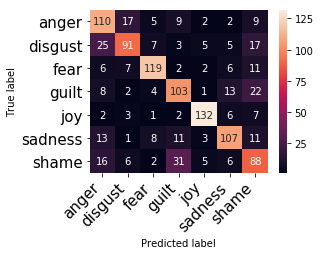

In [43]:
print(print_confusion_matrix(cf_matrix, class_names=dataset.get_labels()))

In [44]:
precision, recall, fscore, support = precision_recall_fscore_support(eval_actual_label_ids, eval_pred_label_ids)
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support.round(4)
}
score_df = pd.DataFrame(score_dict, index=dataset.get_labels())
score_df

,precision,recall,f1-score,support
anger,0.6111,0.7143,0.6587,154
disgust,0.7165,0.5948,0.6500,153
fear,0.8151,0.7778,0.7960,153
guilt,0.6398,0.6732,0.6561,153
joy,0.8800,0.8627,0.8713,153
sadness,0.7379,0.6948,0.7157,154
shame,0.5333,0.5714,0.5517,154


In [45]:
from sklearn.metrics import cohen_kappa_score

kappa_score = cohen_kappa_score(eval_actual_label_ids, eval_pred_label_ids)
print("kappa:", kappa_score)

kappa: 0.6480341147245171


## Test the model

In [46]:
test_result = evaluate('eval', test_features, test_batch_size)
test_loss, test_accuracy, test_pred_label_ids, test_actual_label_ids = test_result

01/25/2019 14:28:50 - INFO - __main__ -   ***** Running eval *****
01/25/2019 14:28:50 - INFO - __main__ -     Num examples = 2300
01/25/2019 14:28:50 - INFO - __main__ -     Batch size = 8


01/25/2019 14:29:18 - INFO - __main__ -   ***** eval results *****
01/25/2019 14:29:18 - INFO - __main__ -     eval_accuracy = 0.7043478260869566
01/25/2019 14:29:18 - INFO - __main__ -     eval_loss = 0.9534986084844503
01/25/2019 14:29:18 - INFO - __main__ -     global_step = 405


In [47]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

cf_matrix = confusion_matrix(test_actual_label_ids, test_pred_label_ids)

df_cm = pd.DataFrame(
    cf_matrix, index=dataset.get_labels(), columns=dataset.get_labels(), 
)

df_cm

,anger,disgust,fear,guilt,joy,sadness,shame
anger,220,27,16,19,8,13,26
disgust,47,223,18,3,2,12,24
fear,10,14,259,13,11,11,10
guilt,28,9,11,219,2,10,49
joy,5,2,10,4,276,14,17
sadness,35,12,15,11,10,227,19
shame,27,11,14,66,7,8,196


Figure(288x216)


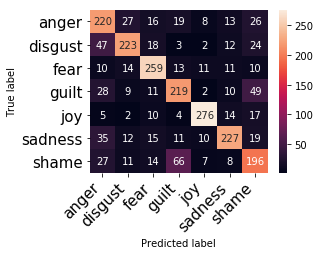

In [48]:
print(print_confusion_matrix(cf_matrix, class_names=dataset.get_labels()))

In [49]:
precision, recall, fscore, support = precision_recall_fscore_support(test_actual_label_ids, test_pred_label_ids)
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support.round(4)
}
score_df = pd.DataFrame(score_dict, index=dataset.get_labels())
score_df

,precision,recall,f1-score,support
anger,0.5914,0.6687,0.6277,329
disgust,0.7483,0.6778,0.7113,329
fear,0.7551,0.7896,0.7720,328
guilt,0.6537,0.6677,0.6606,328
joy,0.8734,0.8415,0.8571,328
sadness,0.7695,0.6900,0.7276,329
shame,0.5748,0.5957,0.5851,329


In [50]:
precision, recall, fscore, support = precision_recall_fscore_support(test_actual_label_ids, test_pred_label_ids, average="micro")
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support
}
score_df = pd.DataFrame(score_dict, index=["score"])
score_df

,precision,recall,f1-score,support
score,0.7043,0.7043,0.7043,None


In [51]:
from sklearn.metrics import cohen_kappa_score

kappa_score = cohen_kappa_score(test_actual_label_ids, test_pred_label_ids)
print("kappa:", kappa_score)

kappa: 0.6550730940693303
